In [1]:
# https://pylessons.com/Beyond-DQN/
import os
import random
import gym
import pylab
import numpy as np

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Lambda, Add, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import cv2

In [2]:
def OurModel(input_shape, action_space, lr):
    X_input = Input(input_shape)

    #X = Conv2D(32, 8, strides=(4, 4),padding="valid", activation="elu", data_format="channels_first", input_shape=input_shape)(X_input)
    #X = Conv2D(64, 4, strides=(2, 2),padding="valid", activation="elu", data_format="channels_first")(X)
    #X = Conv2D(64, 3, strides=(1, 1),padding="valid", activation="elu", data_format="channels_first")(X)
    X = Flatten(input_shape=input_shape)(X_input)

    X = Dense(512, activation="elu", kernel_initializer='he_uniform')(X)
    #X = Dense(256, activation="elu", kernel_initializer='he_uniform')(X)
    #X = Dense(64, activation="elu", kernel_initializer='he_uniform')(X)

    action = Dense(action_space, activation="softmax", kernel_initializer='he_uniform')(X)

    Actor = Model(inputs = X_input, outputs = action)
    Actor.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=lr))

    return Actor

In [3]:
class PGAgent:
    # Policy Gradient Main Optimization Algorithm
    def __init__(self, env_name):
        # Initialization
        # Environment and PG parameters
        self.env_name = env_name
        self.env = gym.make(env_name)
        self.action_size = self.env.action_space.n
        self.EPISODES, self.max_average = 10000, -21.0 # specific for pong
        self.lr = 0.000025

        self.ROWS = 80
        self.COLS = 80
        self.REM_STEP = 4

        # Instantiate games and plot memory
        self.states, self.actions, self.rewards = [], [], []
        self.scores, self.episodes, self.average = [], [], []

        self.Save_Path = 'models'
        self.state_size = (self.REM_STEP, self.ROWS, self.COLS)
        self.image_memory = np.zeros(self.state_size)

        if not os.path.exists(self.Save_Path): os.makedirs(self.Save_Path)
        self.path = '{}_PG_{}'.format(self.env_name, self.lr)
        self.Model_name = os.path.join(self.Save_Path, self.path)

        # Create Actor network model
        self.Actor = OurModel(input_shape=self.state_size, action_space = self.action_size, lr=self.lr)

    def remember(self, state, action, reward):
        # store episode actions to memory
        self.states.append(state)
        action_onehot = np.zeros([self.action_size])
        action_onehot[action] = 1
        self.actions.append(action_onehot)
        self.rewards.append(reward)

    def act(self, state):
        # Use the network to predict the next action to take, using the model
        prediction = self.Actor.predict(state)[0]
        action = np.random.choice(self.action_size, p=prediction)
        return action

    def discount_rewards(self, reward):
        # Compute the gamma-discounted rewards over an episode
        gamma = 0.99    # discount rate
        running_add = 0
        discounted_r = np.zeros_like(reward)
        for i in reversed(range(0,len(reward))):
            if reward[i] != 0: # reset the sum, since this was a game boundary (pong specific!)
                running_add = 0
            running_add = running_add * gamma + reward[i]
            discounted_r[i] = running_add

        discounted_r -= np.mean(discounted_r) # normalizing the result
        discounted_r /= np.std(discounted_r) # divide by standard deviation
        return discounted_r

    def replay(self):
        # reshape memory to appropriate shape for training
        states = np.vstack(self.states)
        actions = np.vstack(self.actions)

        # Compute discounted rewards
        discounted_r = self.discount_rewards(self.rewards)

        # training PG network
        self.Actor.fit(states, actions, sample_weight=discounted_r, epochs=1, verbose=0)
        # reset training memory
        self.states, self.actions, self.rewards = [], [], []

    def load(self, Actor_name):
        self.Actor = load_model(Actor_name, compile=False)

    def save(self):
        self.Actor.save(self.Model_name + '.h5')

    pylab.figure(figsize=(18, 9))
    def PlotModel(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores[-50:]) / len(self.scores[-50:]))
        if str(episode)[-2:] == "00":# much faster than episode % 100
            pylab.plot(self.episodes, self.scores, 'b')
            pylab.plot(self.episodes, self.average, 'r')
            pylab.ylabel('Score', fontsize=18)
            pylab.xlabel('Steps', fontsize=18)
            try:
                pylab.savefig(self.path+".png")
            except OSError:
                pass

        return self.average[-1]

    def imshow(self, image, rem_step=0):
        cv2.imshow(self.Model_name+str(rem_step), image[rem_step,...])
        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            return

    def GetImage(self, frame):
        # croping frame to 80x80 size
        frame_cropped = frame[35:195:2, ::2,:]
        if frame_cropped.shape[0] != self.COLS or frame_cropped.shape[1] != self.ROWS:
            # OpenCV resize function
            frame_cropped = cv2.resize(frame, (self.COLS, self.ROWS), interpolation=cv2.INTER_CUBIC)

        # converting to RGB (numpy way)
        frame_rgb = 0.299*frame_cropped[:,:,0] + 0.587*frame_cropped[:,:,1] + 0.114*frame_cropped[:,:,2]

        # convert everything to black and white (agent will train faster)
        frame_rgb[frame_rgb < 100] = 0
        frame_rgb[frame_rgb >= 100] = 255
        # converting to RGB (OpenCV way)
        #frame_rgb = cv2.cvtColor(frame_cropped, cv2.COLOR_RGB2GRAY)

        # dividing by 255 we expresses value to 0-1 representation
        new_frame = np.array(frame_rgb).astype(np.float32) / 255.0

        # push our data by 1 frame, similar as deq() function work
        self.image_memory = np.roll(self.image_memory, 1, axis = 0)

        # inserting new frame to free space
        self.image_memory[0,:,:] = new_frame

        # show image frame
        #self.imshow(self.image_memory,0)
        #self.imshow(self.image_memory,1)
        #self.imshow(self.image_memory,2)
        #self.imshow(self.image_memory,3)
        return np.expand_dims(self.image_memory, axis=0)

    def reset(self):
        frame = self.env.reset()
        for i in range(self.REM_STEP):
            state = self.GetImage(frame)
        return state

    def step(self, action):
        next_state, reward, done, info = self.env.step(action)
        next_state = self.GetImage(next_state)
        return next_state, reward, done, info

    def run(self):
        for e in range(self.EPISODES):
            state = self.reset()
            done, score, SAVING = False, 0, ''
            while not done:
                self.env.render()
                # Actor picks an action
                action = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.step(action)
                # Memorize (state, action, reward) for training
                self.remember(state, action, reward)
                # Update current state
                state = next_state
                score += reward
                if done:
                    average = self.PlotModel(score, e)
                    # saving best models
                    if average >= self.max_average:
                        self.max_average = average
                        self.save()
                        SAVING = "SAVING"
                    else:
                        SAVING = ""
                    print("episode: {}/{}, score: {}, average: {:.2f} {}".format(e, self.EPISODES, score, average, SAVING))

                    self.replay()

        # close environemnt when finish training
        self.env.close()

    def test(self, Model_name):
        self.load(Model_name)
        for e in range(100):
            state = self.reset()
            done = False
            score = 0
            while not done:
                self.env.render()
                action = np.argmax(self.Actor.predict(state))
                state, reward, done, _ = self.step(action)
                score += reward
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, score))
                    break
        self.env.close()

<Figure size 1296x648 with 0 Axes>

d:\workspace\trading\study\.env\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
d:\workspace\trading\study\.env\lib\site-packages\gym\envs\atari\environment.py:255: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  logger.warn(
d:\workspace\trading\study\.env\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


episode: 0/10000, score: -20.0, average: -20.00 SAVING
episode: 1/10000, score: -21.0, average: -20.50 
episode: 2/10000, score: -19.0, average: -20.00 SAVING
episode: 3/10000, score: -18.0, average: -19.50 SAVING
episode: 4/10000, score: -20.0, average: -19.60 
episode: 5/10000, score: -20.0, average: -19.67 
episode: 6/10000, score: -20.0, average: -19.71 
episode: 7/10000, score: -20.0, average: -19.75 
episode: 8/10000, score: -20.0, average: -19.78 
episode: 9/10000, score: -18.0, average: -19.60 
episode: 10/10000, score: -21.0, average: -19.73 
episode: 11/10000, score: -21.0, average: -19.83 
episode: 12/10000, score: -21.0, average: -19.92 
episode: 13/10000, score: -20.0, average: -19.93 
episode: 14/10000, score: -21.0, average: -20.00 
episode: 15/10000, score: -20.0, average: -20.00 
episode: 16/10000, score: -20.0, average: -20.00 
episode: 17/10000, score: -20.0, average: -20.00 
episode: 18/10000, score: -21.0, average: -20.05 
episode: 19/10000, score: -20.0, average: 

KeyboardInterrupt: 

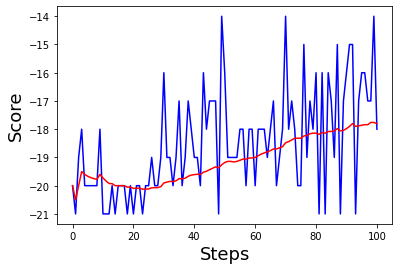

In [4]:
env_name = 'Pong-v0'
#env_name = 'PongDeterministic-v4'
agent = PGAgent(env_name)
agent.run()
#agent.test('models/PongDeterministic-v4_PG_2.5e-05.h5')
# agent.test('models/Pong-v0_PG_2.5e-05.h5')